<h2>Import necessary libraries

In [2]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import joblib

<h2>loading and preprocessing

In [11]:


# Load dataset (replace with the correct file path)
df = pd.read_csv("Dataset/preprocessed_smart_grid_dataset.csv")

# Convert Timestamp and extract Hour
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Hour"] = df["Timestamp"].dt.hour

# Define Peak Hour (Top 10% power consumption)
peak_threshold = df["Power Consumption (kW)"].quantile(0.90)
df["Peak Hour"] = (df["Power Consumption (kW)"] >= peak_threshold).astype(int)

# Selecting features
features = ["Hour", "Power Consumption (kW)"]
target = "Peak Hour"

# Separate Peak and Non-Peak hours
df_peak = df[df["Peak Hour"] == 1]  # Get all peak hour samples
df_non_peak = df[df["Peak Hour"] == 0].sample(n=len(df_peak), random_state=42)  # Downsample non-peak hours

# Combine balanced dataset
df_balanced = pd.concat([df_peak, df_non_peak]).sample(frac=1, random_state=42)  # Shuffle dataset
scaler = MinMaxScaler()
df_balanced[features] = scaler.fit_transform(df_balanced[features])  # ✅ Correct dataset

# Save the scaler
joblib.dump(scaler, "scaler.pkl")





['scaler.pkl']

<h2>counting the peak hours

In [19]:

# Convert Timestamp and extract Hour
df_balanced["Timestamp"] = pd.to_datetime(df["Timestamp"])
df_balanced["Hour"] = df["Timestamp"].dt.hour

# Define Peak Hour (Top 10% power consumption)
peak_threshold = df_balanced["Power Consumption (kW)"].quantile(0.90)
df_balanced["Peak Hour"] = (df_balanced["Power Consumption (kW)"] >= peak_threshold).astype(int)

# Selecting features
features = ["Hour", "Power Consumption (kW)"]
target = "Peak Hour"

# Normalize features
scaler = MinMaxScaler()
df_balanced[features] = scaler.fit_transform(df[features])


print(df_balanced["Peak Hour"].value_counts(normalize=True))



ValueError: Length of values (50000) does not match length of index (10000)

<h2>feautre selection

In [21]:
# Prepare input and target variables
X = df_balanced[features].values
y = df_balanced[target].values

# Reshape input for LSTM (samples, time steps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)




<h2>model building

In [22]:
# Build LSTM Model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(1, len(features))),
    Dropout(0.3),  # Higher dropout
    LSTM(100),
    Dropout(0.3),
    Dense(1, activation='sigmoid') # Binary classification output
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20


c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6546 - loss: 0.5683 - val_accuracy: 0.9640 - val_loss: 0.1051
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9621 - loss: 0.1085 - val_accuracy: 0.9795 - val_loss: 0.0537
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9751 - loss: 0.0698 - val_accuracy: 0.9775 - val_loss: 0.0483
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9813 - loss: 0.0525 - val_accuracy: 0.9850 - val_loss: 0.0359
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9871 - loss: 0.0418 - val_accuracy: 0.9915 - val_loss: 0.0259
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9874 - loss: 0.0349 - val_accuracy: 0.9850 - val_loss: 0.0344
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9887 - loss: 0.0353 - val_accuracy: 0.9965 - val_loss: 0.0241
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9852 - loss: 0.0399 - val_accuracy: 0.9920 - val_

<h2>ploting

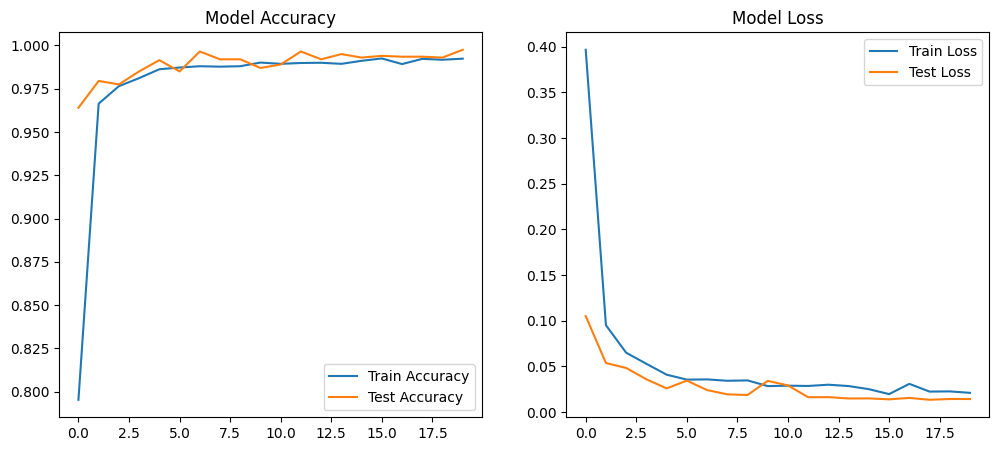

Model saved successfully!


In [23]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

# Save the trained model
model.save("lstm_peak_hour_model2.h5")
print("Model saved successfully!")

<h2>testing and validation

<h2>raw predictions


In [27]:
from tensorflow.keras.models import load_model
model = load_model("lstm_peak_hour_model2.h5")  # Replace with your saved model path

sample_inputs = np.array([[0, 2.0], [12, 5.0], [18, 4.5]])  # Sample Hours and Power
sample_inputs = scaler.transform(sample_inputs)  # Normalize using saved scaler
sample_inputs = sample_inputs.reshape((sample_inputs.shape[0], 1, sample_inputs.shape[1]))

predictions = model.predict(sample_inputs)
print("Raw Predictions:", predictions)  # Print probabilities


c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
Raw Predictions: [[1.]
 [1.]
 [1.]]


<h2>testing

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load test dataset
test_df = pd.read_csv("your_test_data.csv")  # Replace with test data path

# Convert timestamp and extract hour
test_df["Timestamp"] = pd.to_datetime(test_df["Timestamp"])
test_df["Hour"] = test_df["Timestamp"].dt.hour

# Normalize using the same MinMaxScaler
scaler = MinMaxScaler()
test_df[["Hour", "Power Consumption (kW)"]] = scaler.fit_transform(test_df[["Hour", "Power Consumption (kW)"]])

# Select features for testing
X_test = test_df[["Hour", "Power Consumption (kW)"]].values


In [7]:


# Load the .h5 model
model = tf.keras.models.load_model("lstm_peak_hour_model2.h5")

# Convert to TensorFlow SavedModel format
model.export("saved_model/")




INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 2), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1891565676176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1891565678672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1891565679248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1891565678096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1891565680592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1891565681168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1891565680784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1891565681936: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
# Optionally, convert to ONNX format for faster inference

import tf2onnx

onnx_model = tf2onnx.convert.from_keras(model)
with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())